#### Going to train a full redshift flow for the rail forward modeling

In [1]:
import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import corner
import pandas as pd

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.distributions import Joint, Normal, Uniform

In [2]:
# plotting style
plt.style.use('../paper.mplstyle')
twocol = 7.1014
onecol = 3.35
mpl.rcParams["xtick.major.size"] = 2.5
mpl.rcParams["ytick.major.size"] = 2.5

#### Load the DC2 data

In [3]:
data = pd.read_pickle("dc2.pkl")
data

,redshift,u,g,r,i,z,y,ra,dec,size,ellipticity
0,0.088567,26.408892,25.052967,24.382580,24.054487,23.862051,23.780313,68.140241,-36.593690,0.228518,0.063050
1,1.669109,27.594755,27.341902,26.978935,26.064869,25.297333,24.829222,63.595239,-42.737808,0.157922,0.103562
2,1.159747,25.647858,25.738802,25.805744,25.816053,25.336340,25.312277,65.058580,-34.124349,0.044984,0.077182
3,1.243086,20.772106,20.849342,21.003485,21.068716,20.777245,20.585878,67.102727,-37.531376,0.731108,0.068541
4,0.495375,27.616890,26.316532,25.005684,24.470062,24.259823,24.124353,60.895633,-37.089175,0.136636,0.690425
...,...,...,...,...,...,...,...,...,...,...,...
999995,1.801396,25.059799,24.743279,24.634626,24.544033,24.275795,24.118439,67.129082,-45.451003,0.188007,0.284175
999996,1.704218,25.937052,25.833080,25.912664,25.534258,25.070293,24.750761,62.435367,-39.432315,0.318020,0.093354
999997,0.149601,26.392920,25.087479,24.551336,24.330084,24.194437,24.139854,67.479172,-37.236422,0.411841,0.412781
999998,1.556581,25.935816,25.960798,26.087328,25.866976,25.731079,25.296770,63.362970,-42.674246,0.266826,0.102412


In [4]:
# select the redshifts and photometry
data = data[["redshift", "u", "g", "r", "i", "z", "y"]]
# create training and test sets
trainset = data.sample(frac = 0.8, random_state = 0).sort_index()
testset = data.drop(trainset.index)
del data

#### Create a flow to model the data

In [5]:
# set the Color Transform reference index
# to use the r band as the reference magnitude
ref_idx = trainset.columns.get_loc("r")
# set the column indices for the magnitudes we want colors from
mag_idx = [trainset.columns.get_loc(col) for col in ["u","g","r","i","z","y"]]

# set the inverse softplus parameters, 
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 10

# calculate the mean and standard deviations of the dimensions
# note that on this side of the color transform, we are working
# in color space, so I calculate the mean and std dev of these 
# variables instead of the raw magnitudes
data_temp = np.array([trainset['redshift'], 
                      trainset['r'], 
                      trainset['u'] - trainset['g'], 
                      trainset['g'] - trainset['r'], 
                      trainset['r'] - trainset['i'], 
                      trainset['i'] - trainset['z'], 
                      trainset['z'] - trainset['y']]).T

means = data_temp.mean(axis=0)
stds = data_temp.std(axis=0)
del data_temp

# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = trainset.shape[1]

# construct our bijector
# by chaining all these layers
bijector = Chain(
    ColorTransform(ref_idx, mag_idx),
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers, K=2, transformed_dim=1, B=5),
)

flow = Flow(trainset.columns, bijector)

#### Train the flow

In [7]:
%%time
losses = flow.train(trainset, epochs=200, verbose=True)

Training 200 epochs 
Loss:
10.5755
-5.4337
-7.9678
-8.3596
-8.3863
-9.1736
-9.0363
-9.3207
-9.0029
-9.5517
-9.1891
-9.5444
-9.4325
-9.5473
-9.6152
-9.7423
-9.9075
-9.8433
-9.5401
-10.1043
-9.6423
CPU times: user 11h 32min 38s, sys: 3h 52min 4s, total: 15h 24min 42s
Wall time: 2h 14min 24s


Let's print the test loss

In [8]:
-np.mean(flow.log_prob(testset))

DeviceArray(-9.770205, dtype=float32)

#### Plot the results

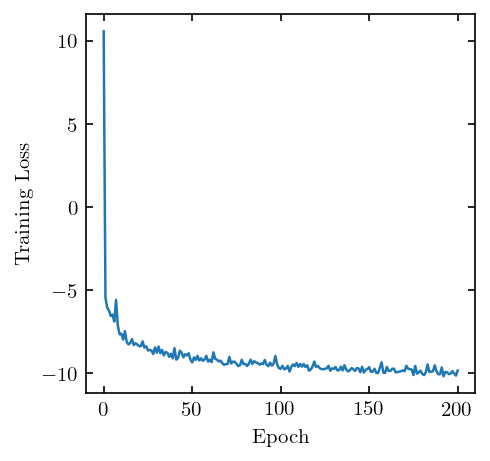

In [9]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

In [5]:
#flow = Flow(file="saved-flows/desc-dc2-redshift-flow.pkl")

In [6]:
samples = flow.sample(10000, seed=0)

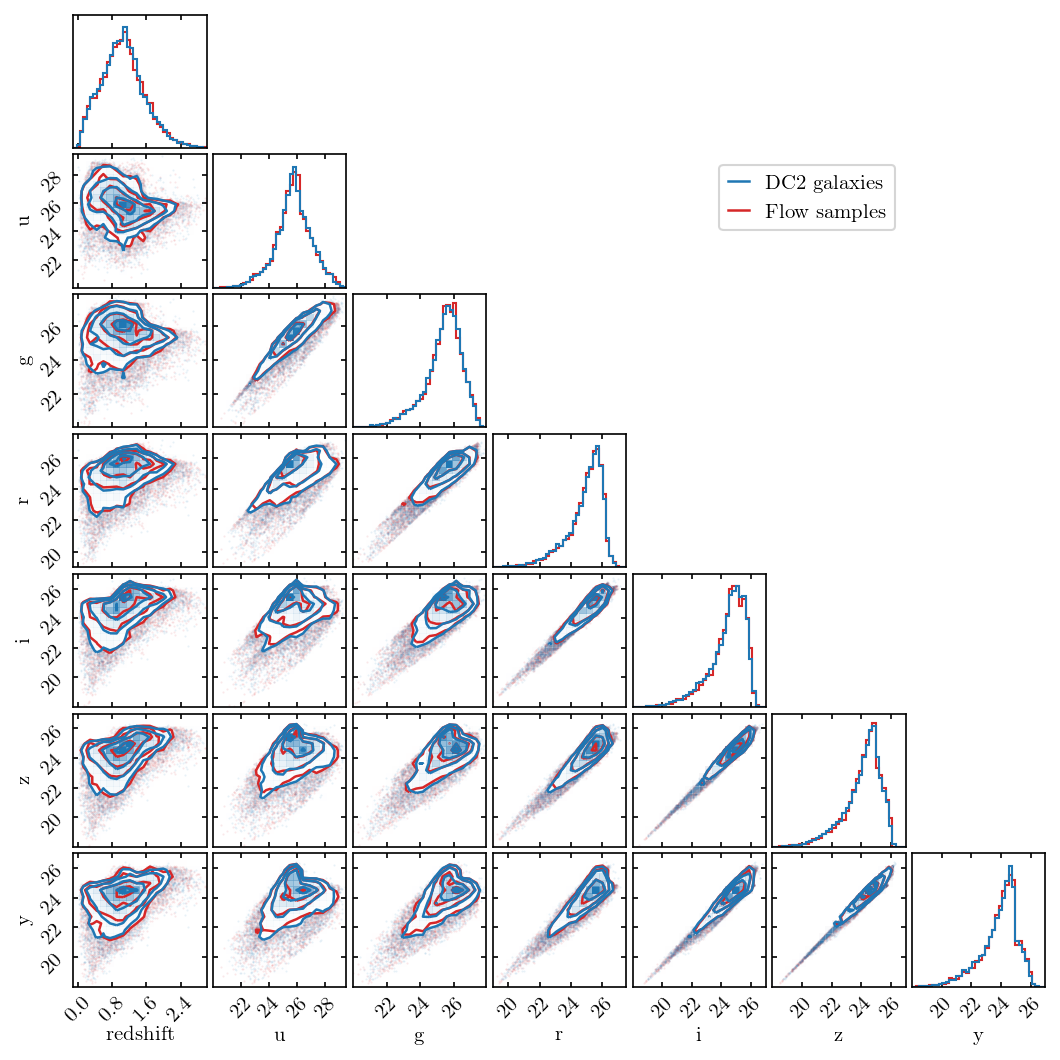

In [16]:
fig = plt.figure(figsize=(twocol, twocol))

ranges = [(-0.1,3), (20,29.5), (20,27.9), (19,27.5), (18,27), (18,27), (18,27)]

corner.corner(trainset[:10000], fig=fig, bins=20, range=ranges, hist_bin_factor=2, color='C3', data_kwargs={"marker":"."},
              labels=["redshift", "u", "g", "r", "i", "z", "y"])

corner.corner(samples, fig=fig, color='C0', bins=20, range=ranges, hist_bin_factor=2, data_kwargs={"marker":"."})

# extract the axes
axes = onp.array(fig.axes).reshape((7, 7))

# create the legend
axes[1,5].plot([], [], c="C0", label="DC2 galaxies")
axes[1,5].plot([], [], c="C3", label="Flow samples")
axes[1,5].legend(handlelength=1, loc="upper right")

fig.savefig("figures/flow-corner.pdf")

#### Save the flow

In [13]:
flow.info = f"""
Flow for the forward model section of the pzflow paper.
Trained on a million galaxies from DESC CosmoDC2.

This flow was created with pzflow version {pzflow.__version__}
"""

In [14]:
flow.save("saved-flows/desc-dc2-redshift-flow.pkl")